In [1]:
# -------------------------------------------------------------------------------------- #
# ---------- DISCRETE DIPOLE METHOD FOR UV-VIS CALCULATIONS FROM DIPOLE DATA ----------- #
# -------------------------------------------------------------------------------------- #
import os
import json
import pathlib
import numpy as np
import pandas as pd
from dda_complex128 import DDA
import tensorflow as tf
import fresnel
from matplotlib import pyplot as plt
def delete_1D(new_position,position):
    A=np.array(np.around(new_position,7)).tolist()
    B=np.array(np.around(position,7)).tolist()
    A = [i for i in A if i not in B]
    return A

2022-02-25 10:25:12.587476: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# GPU Device Config
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"
current_folder_path = pathlib.Path().absolute()

In [3]:
# get the initial dipole position
position = []
for x in range(-100,100):
    for y in range(-100,100):
        for z in range(-100,100):
            if abs(x)+abs(y)+abs(z)<=16:
                position.append([x,y,z])
position = np.array(position)
scene = fresnel.Scene()
geometry = fresnel.geometry.Sphere(scene, N=len(position), radius=np.sqrt(2)/2)
geometry.position[:] = position
geometry.material = fresnel.material.Material(color=fresnel.color.linear([0.9, 0.714, 0.169]), roughness = 0.2)
scene.camera = fresnel.camera.Orthographic.fit(scene)
fresnel.preview(scene)

np.savetxt('./data3/dipoles.csv',position,delimiter=',')

# Benchmark from tiny cube to growth into nanorods

In [4]:
data_path = "./data3"
# define the intial and final dipole sets
config = {'gpu_device': '/GPU:0',
            'dipole_length': 0.41,
            'min_wavelength': 0.52,
            'max_wavelength': 0.57,
            'num_wavelengths': 26,
            'ref_medium': 1.333,
            'rotation_steps': 10,
            'folder_path': data_path,
            'calculate_electricField': False,
            'ref_data': [str(current_folder_path) + '/Au_ref_index.csv',str(current_folder_path) + '/Ag_ref_index.csv'],
            'metals': ["Au","Ag"],
            'dipole_data': str(current_folder_path) + '/data3/dipoles.csv',
            "ratio":[1.0, 0],
            "lattice_constant":0.41,
            "method":"homo",
            "atom_data":None
           }

In [5]:
changed_dipole_index = [int(i) for i in np.loadtxt('./data3/changed_dipole_index.csv',delimiter=',')]
changed_dipole_type = np.loadtxt('./data3/changed_dipole_type.csv',delimiter=',')

In [6]:
rate = 10**6
np_dda = DDA(config)
alpha_j1 = np.array([np.repeat(np_dda.alpha_j[:,i],3) for i in range(np_dda.alpha_j.shape[1])]).T
alpha_j2 = np.array([np.repeat(np_dda.alpha_j[:,i],3)/rate for i in range(np_dda.alpha_j.shape[1])]).T

extra_index = [int(i) for i in changed_dipole_index]
atom_index = [[i for i in range(3*j,3*j+3)] for j in extra_index]
atom_index = np.array(atom_index).flatten().tolist()

np_dda.flip_infor = [atom_index,alpha_j1,alpha_j2]

Reading refractive index and dipole data
Calculating radius of the cross section and polarizability


In [ ]:
t_total = np_dda.calculate_spectrum_trajectories_v2_1()
t_total = np.array(t_total)
np.savetxt(data_path+f'/data_rod_growth2_t_{rate}_128_test_extra_points.csv',t_total,delimiter=',')
np.savetxt(data_path+f'/C_cross_total2_{rate}_128_test_extra_points.csv',np.array(np_dda.C_cross_total),delimiter=',')

In [11]:
data_path = "./data3"
rate = 10**6
data2_extra = np.loadtxt(data_path+f'/C_cross_total2_{rate}_128_test_extra_points.csv',delimiter=',')
data2 = np.loadtxt(data_path+f'/C_cross_total2_{rate}_128_test.csv',delimiter=',')
data_total = np.vstack((data2,data2_extra))
wavelength = np.concatenate((np.linspace(0.45,0.70,26),np.linspace(0.52,0.57,26)))
wavelength = np.around(wavelength,3)
r,_ = np.unique(wavelength,return_index=True)
data_total = data_total[_]
wavelength = wavelength[_]

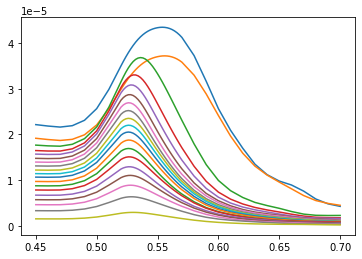

In [12]:
for i in range(int(data_total.shape[1]/800)):
    plt.plot(wavelength,data_total[:,800*i])
plt.plot(wavelength,data_total[:,-1])
plt.show()

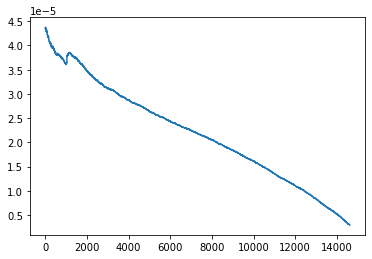

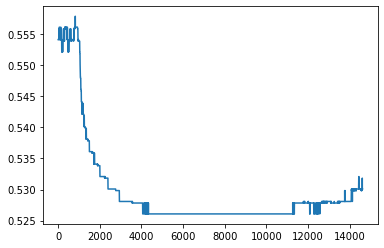

In [13]:
from scipy.interpolate import interp1d
I = []
wv= []
sample_wavlength = np.linspace(0.45,0.70,1000)
for i in range(int(data_total.shape[1])):
    f = interp1d(wavelength, data_total[:,i])
    I.append(f(sample_wavlength).max())
    wv.append(sample_wavlength[f(sample_wavlength) == f(sample_wavlength).max()])
    
plt.plot(I)
plt.show()

plt.plot(wv)
plt.show()